In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

# Objective 1
As a data scientist, you are tasked by your retail business client with identifying two
groups of people for marketing purposes:

- People who earn an income of less than $50,000 and those who earn more than
$50,000. 
- To assist in this pursuit, Walmart has developed a means of accessing 40
different demographic and employment related variables for any person they are
interested in marketing to. 
- Additionally, Walmart has been able to compile a
dataset that provides gold labels for a variety of observations of these 40
variables within the population. 
- Using the dataset given, train and validate a
classifier that predicts this outcome.

## Data
[Census-Income (KDD)](https://archive.ics.uci.edu/dataset/117/census+income+kdd)
weighted census data extracted from the 1994 and 1995

Each line of the data set (censusbureau.data) contains 
- 40 demographic and employment related variables as well as 
- a weight for the observation 
    - The weight indicates the relative distribution of people in the general population that each record represents due to stratified sampling
- a label for each observation, 
    - which indicates whether a particular population component had an income that is greater than or less than $50k

### 1. Load the data

In [3]:
with open('../data/census-bureau.columns', 'r') as f:
    columns = f.read().splitlines()
    print(columns)

df = pd.read_csv('../data/census-bureau.data', header=None, names=columns)
print(df.shape)
print(df.info())
df.head()

['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'weeks worked 

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
print(df.shape)
df.info()
df.head()

(199523, 42)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital stat                                199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-nu

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [5]:
# Separate the weight and label columns for the dataset
weights = df['weight']
labels = df['label']
features = df.drop(columns=['weight', 'label'])
features.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94


In [6]:
# One-hot encode label column
labels = labels.map({'- 50000.': 0, '50000+.': 1})

### 2. EDA

#### Label 

In [7]:
# see if there is class imbalance
df['label'].value_counts(normalize=True)

label
- 50000.    0.937942
50000+.     0.062058
Name: proportion, dtype: float64

In [8]:
# Inspect label distribution using stratified sampling weights
print(f"Percentage of people that earn {df['label'].unique()[0]} among all population (with weights): {weights[df['label'] == df['label'].unique()[0]].sum() / weights.sum():.4f}.")

Percentage of people that earn - 50000. among all population (with weights): 0.9359.


#### Numeric Features

In [9]:
# Insepect the number of unique values for each feature
features.nunique().sort_values(ascending=True)

year                                             2
sex                                              2
veterans benefits                                3
fill inc questionnaire for veteran's admin       3
own business or self employed                    3
enroll in edu inst last wk                       3
live in this house 1 year ago                    3
member of a labor union                          3
migration prev res in sunbelt                    4
citizenship                                      5
family members under 18                          5
race                                             5
region of previous residence                     6
reason for unemployment                          6
tax filer stat                                   6
num persons worked for employer                  7
marital stat                                     7
full or part time employment stat                8
detailed household summary in household          8
class of worker                

In [10]:
# Identify numeric features
numeric_cols = features.nunique()[features.nunique() > 52].index.tolist()
print(numeric_cols)

['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'weeks worked in year']


In [11]:
# Is there any missing data in numeric features?
features[numeric_cols].isnull().sum()

age                      0
wage per hour            0
capital gains            0
capital losses           0
dividends from stocks    0
weeks worked in year     0
dtype: int64

In [12]:
features['major industry code'].value_counts()

major industry code
Not in universe or children            100684
Retail trade                            17070
Manufacturing-durable goods              9015
Education                                8283
Manufacturing-nondurable goods           6897
Finance insurance and real estate        6145
Construction                             5984
Business and repair services             5651
Medical except hospital                  4683
Public administration                    4610
Other professional services              4482
Transportation                           4209
Hospital services                        3964
Wholesale trade                          3596
Agriculture                              3023
Personal services except private HH      2937
Social services                          2549
Entertainment                            1651
Communications                           1181
Utilities and sanitary services          1178
Private household services                945
Mining        

In [13]:
features['tax filer stat'].value_counts()

tax filer stat
Nonfiler                        75094
Joint both under 65             67383
Single                          37421
Joint both 65+                   8332
Head of household                7426
Joint one under 65 & one 65+     3867
Name: count, dtype: int64

In [37]:
features['education'].nunique()

17

<Figure size 1200x1000 with 0 Axes>

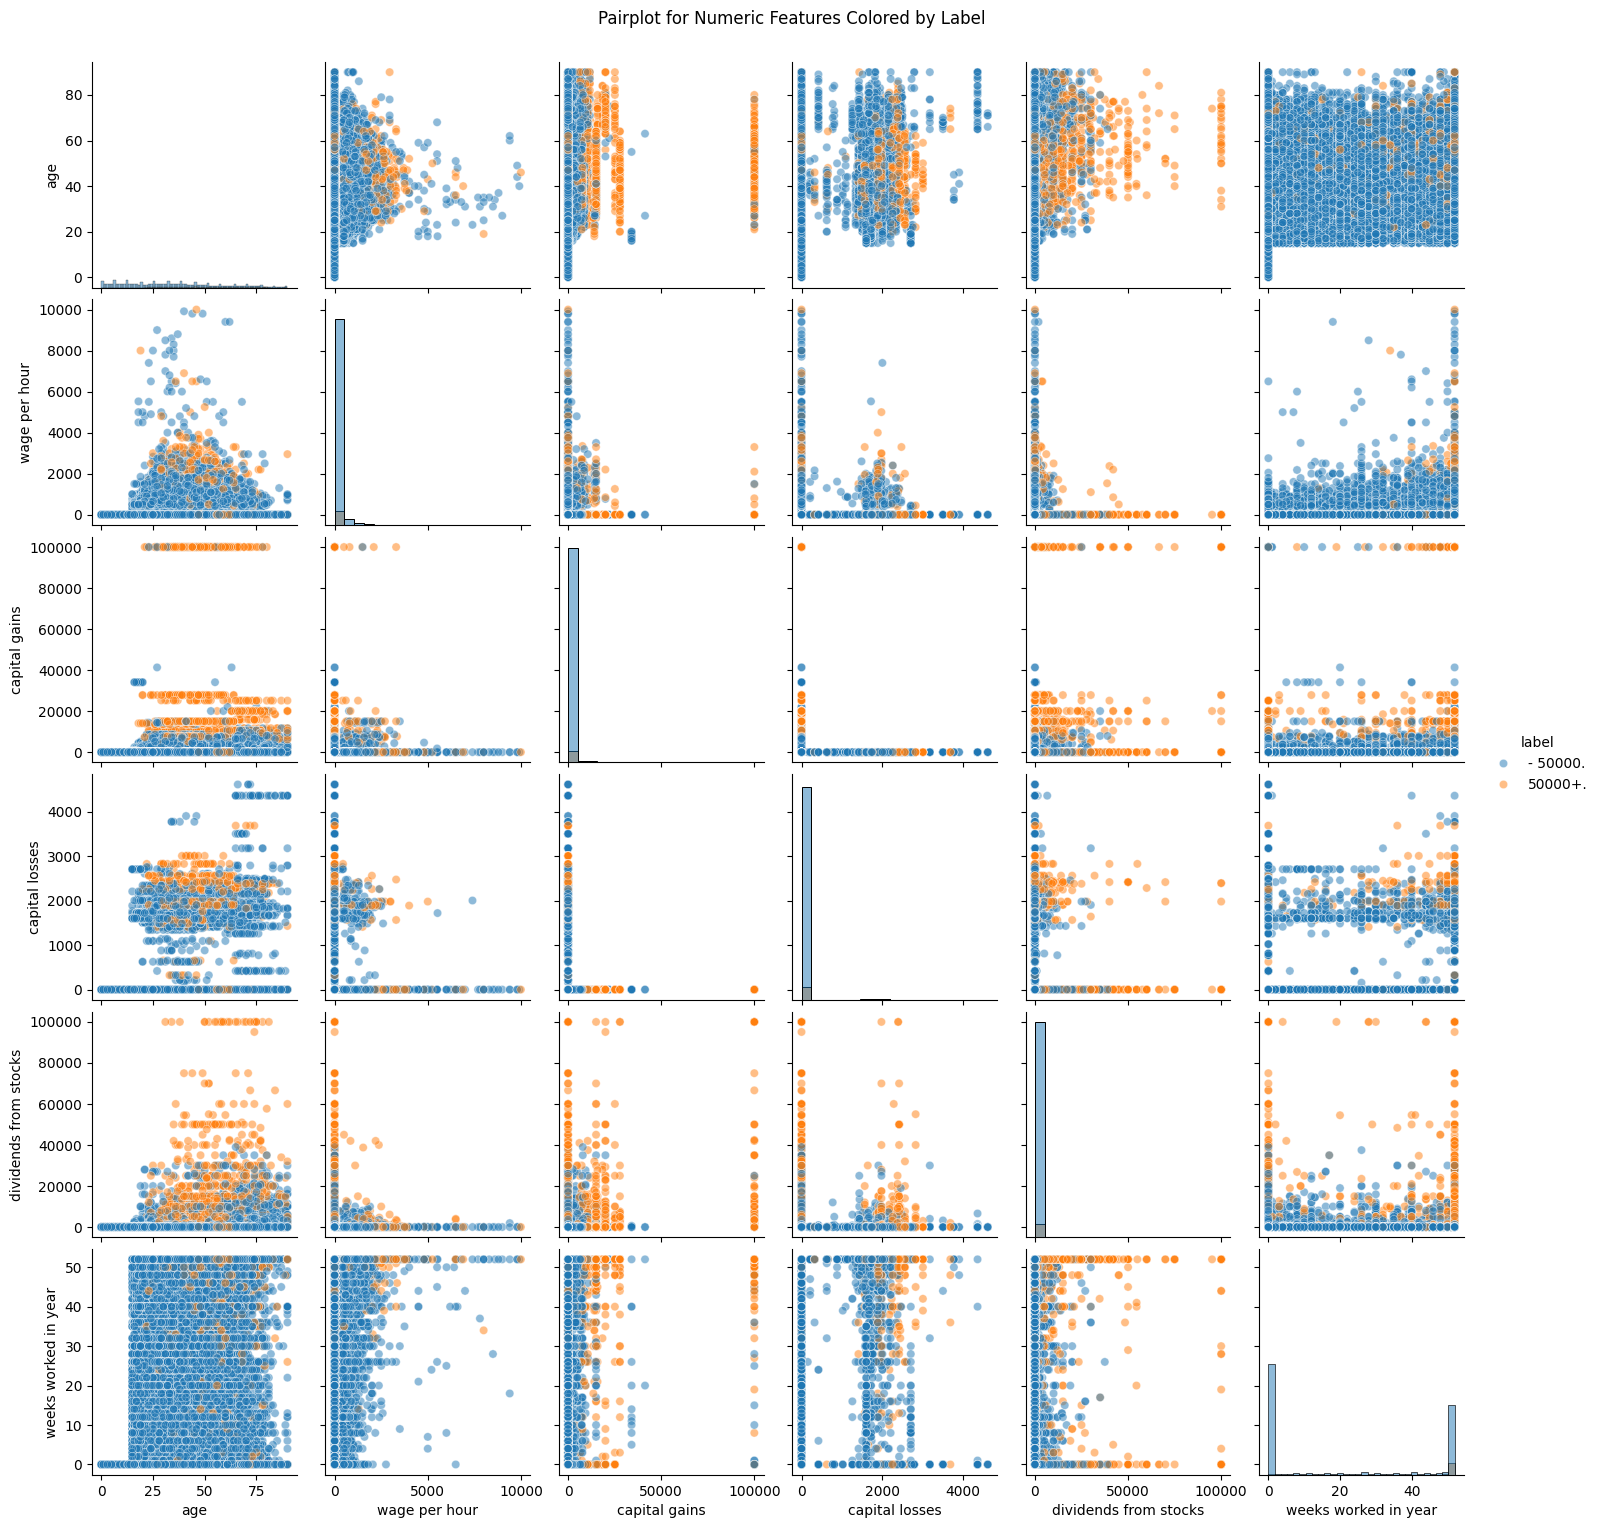

In [14]:
# Plot pairplot for numeric features and color by label
plt.figure(figsize=(12, 10))
sns.pairplot(df[numeric_cols + ['label']], hue='label', diag_kind='hist', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot for Numeric Features Colored by Label', y=1.02)
plt.show()

Anlaysis for the pairplot:
- On the diagonals for `wage per hour`, `capital gains`, `capital losses`, and `dividends` from stocks: the histograms are overwhelmingly dominated by a single bar at zero. 

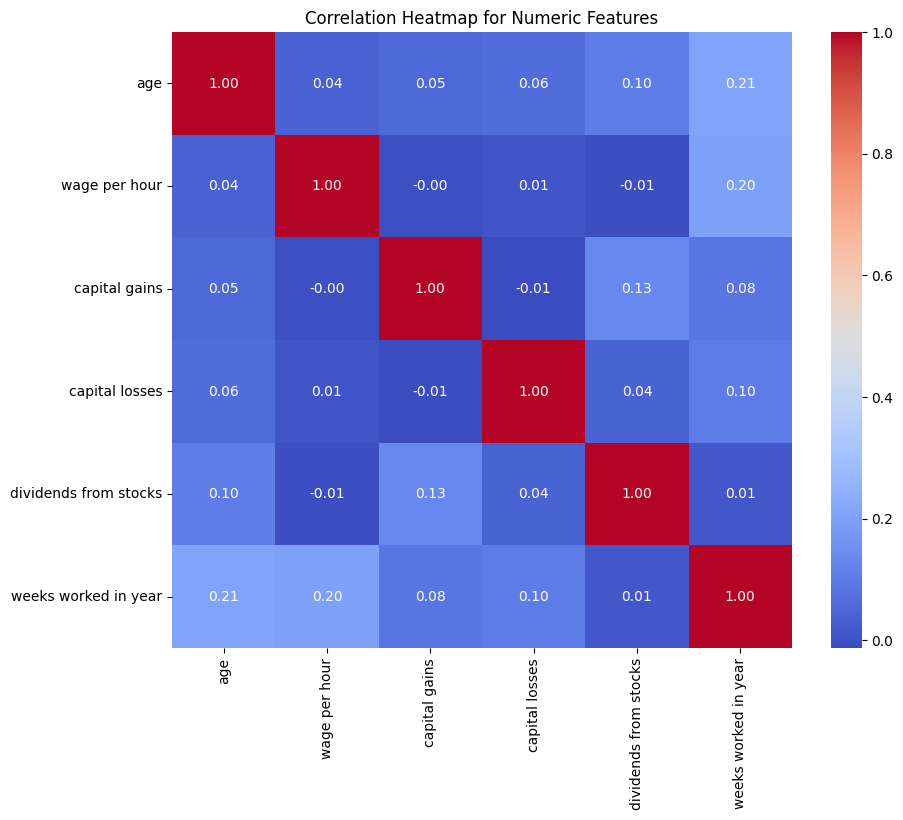

In [15]:
# Plot correlation heatmap for numeric features
plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap for Numeric Features')
plt.show()

In [43]:
76.5 * 35.2 * 40

107712.0

In [40]:
# proportion counts for categorical features
features['race'].value_counts(normalize=True) * 100

race
White                          83.882560
Black                          10.231903
Asian or Pacific Islander       2.924475
Other                           1.832871
Amer Indian Aleut or Eskimo     1.128191
Name: proportion, dtype: float64

#### Categorical Features

In [16]:
# Identify one-hot encoded features: those that are not numeric
categorical_cols = [ col for col in features.columns if col not in numeric_cols ]
print(len(categorical_cols))
features[categorical_cols].nunique().sort_values(ascending=True)

34


year                                           2
sex                                            2
fill inc questionnaire for veteran's admin     3
own business or self employed                  3
live in this house 1 year ago                  3
enroll in edu inst last wk                     3
veterans benefits                              3
member of a labor union                        3
migration prev res in sunbelt                  4
family members under 18                        5
citizenship                                    5
race                                           5
reason for unemployment                        6
tax filer stat                                 6
region of previous residence                   6
num persons worked for employer                7
marital stat                                   7
detailed household summary in household        8
full or part time employment stat              8
migration code-change in reg                   9
class of worker     

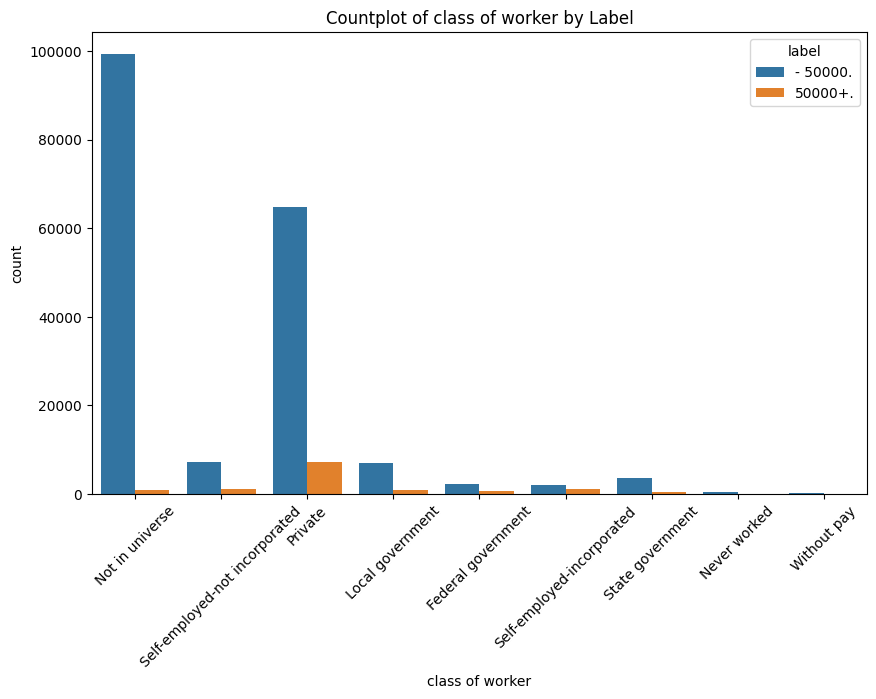

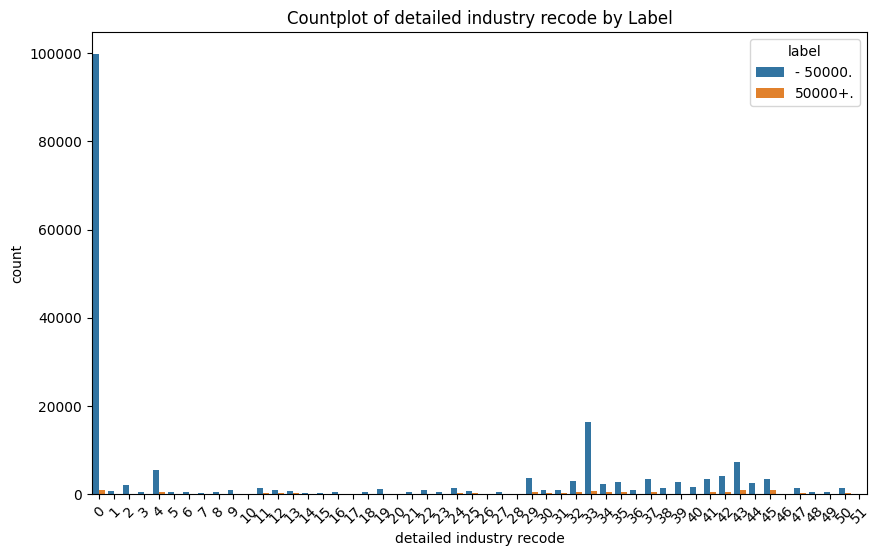

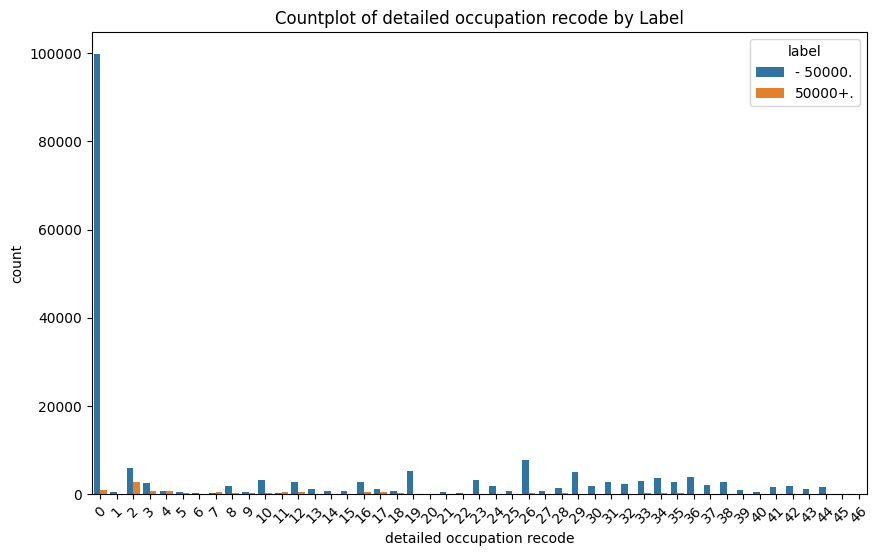

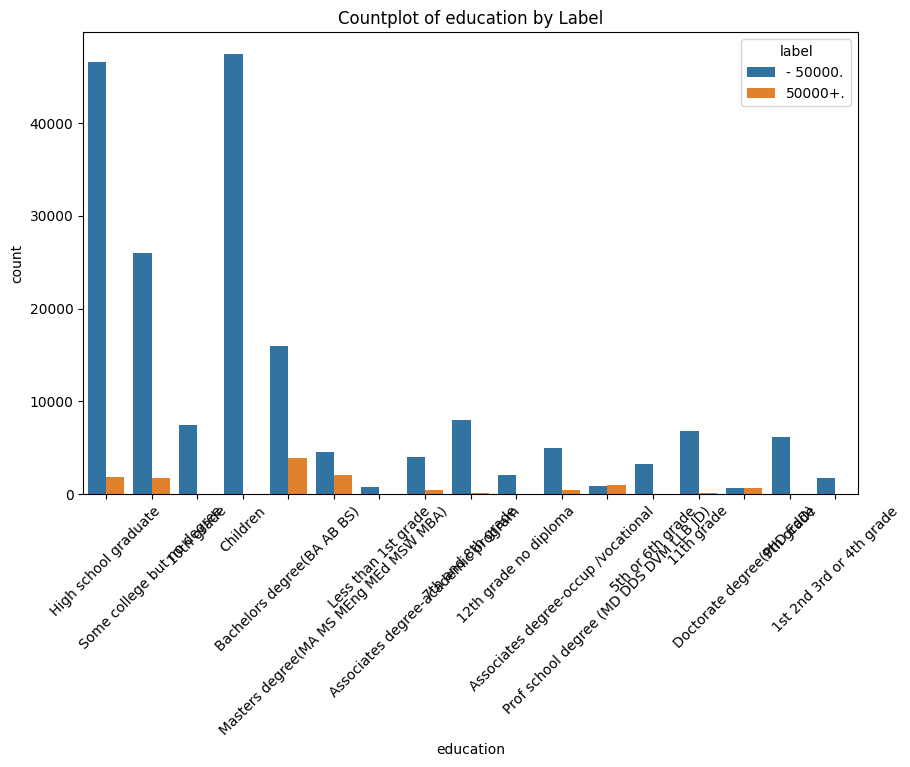

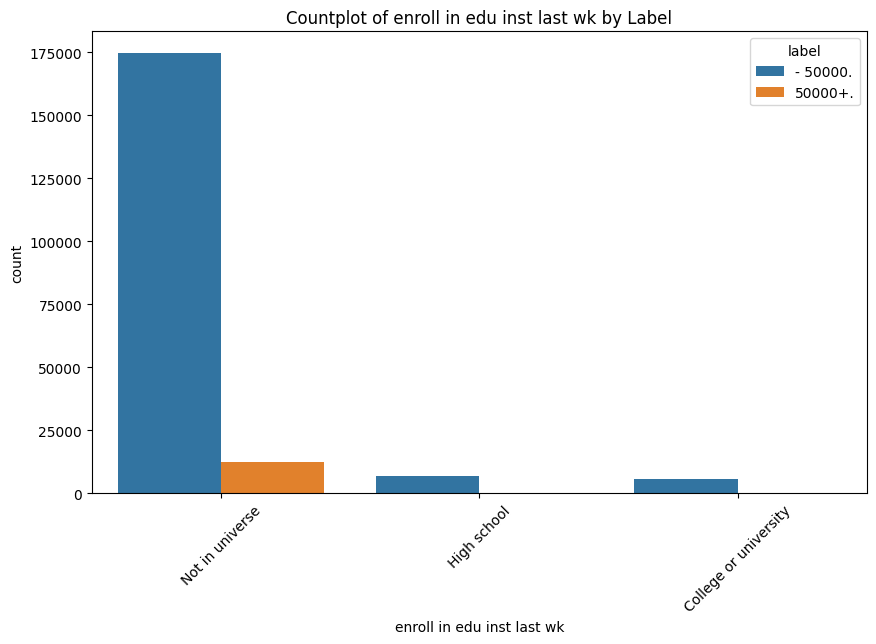

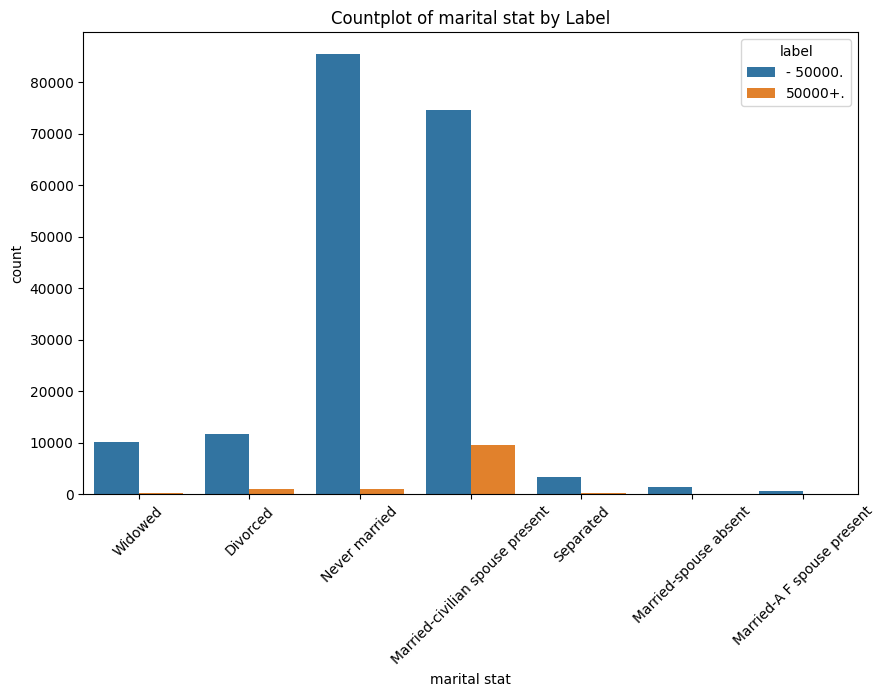

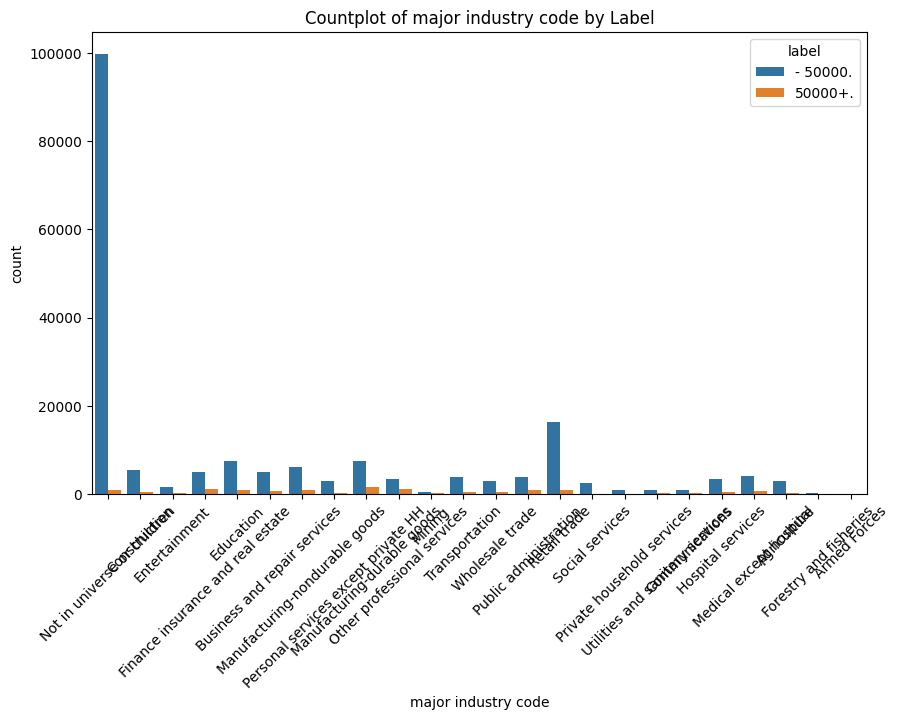

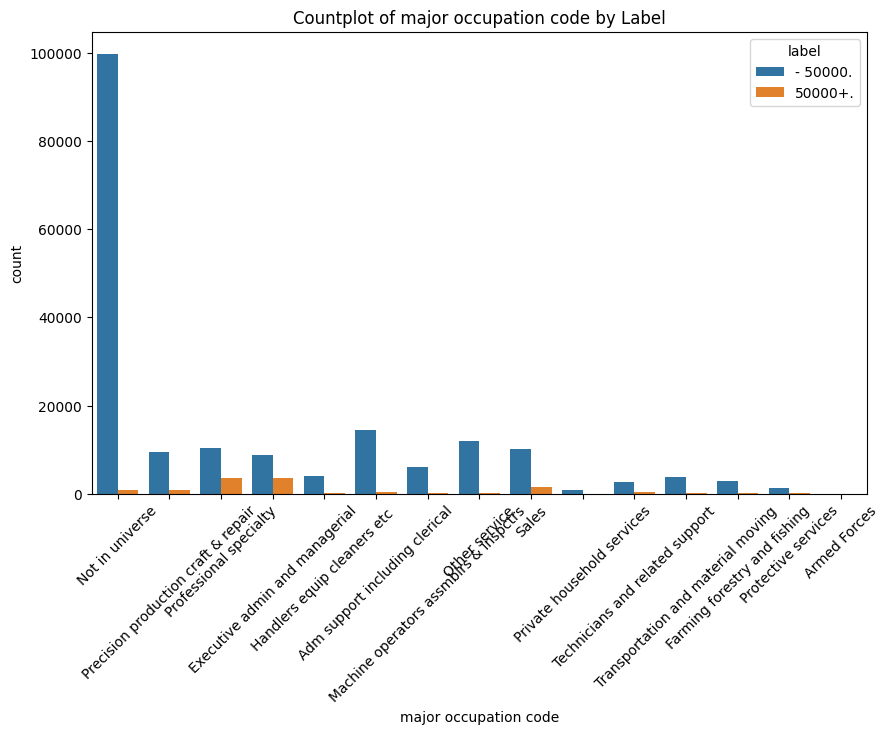

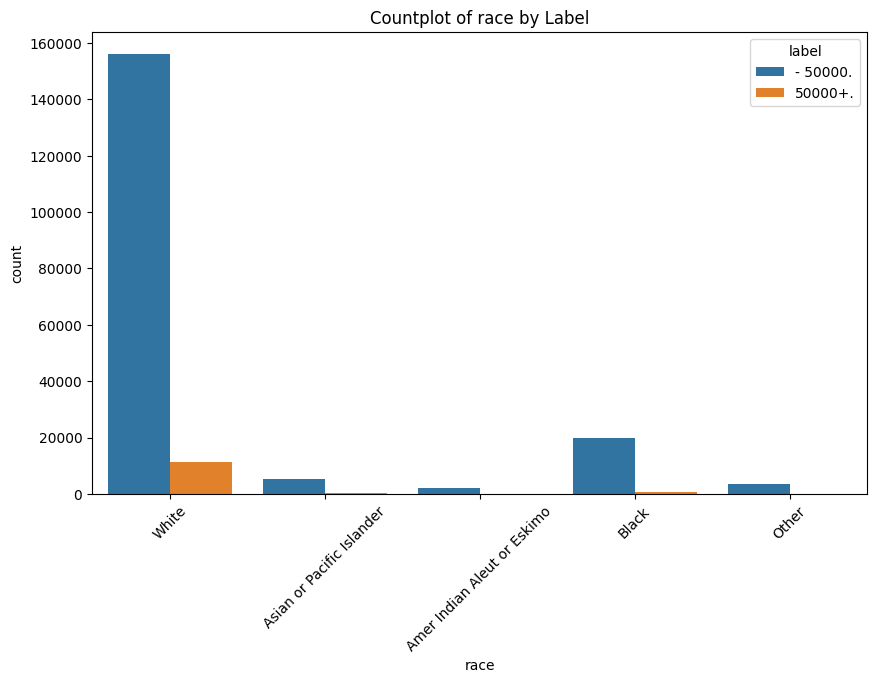

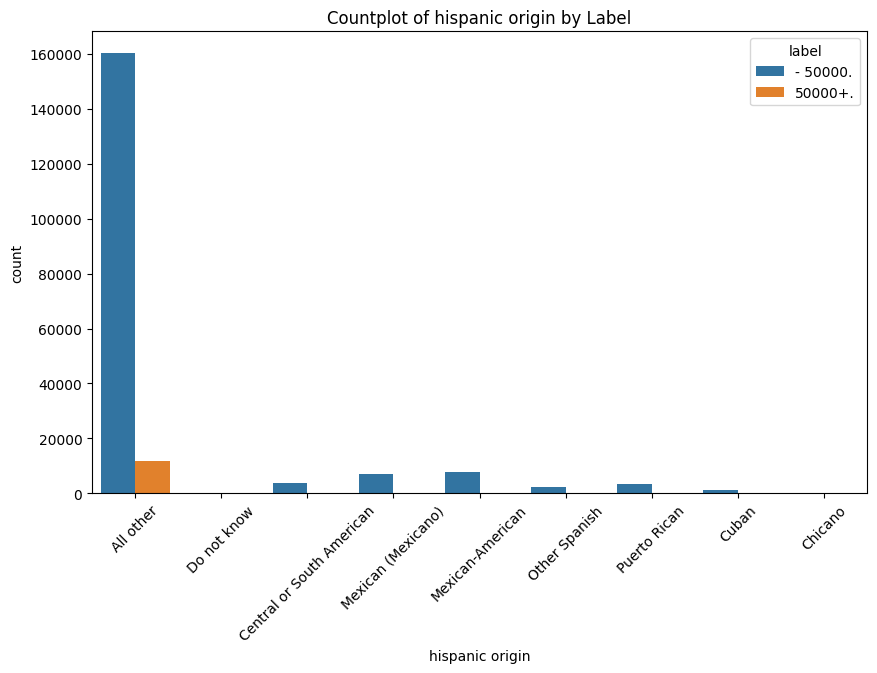

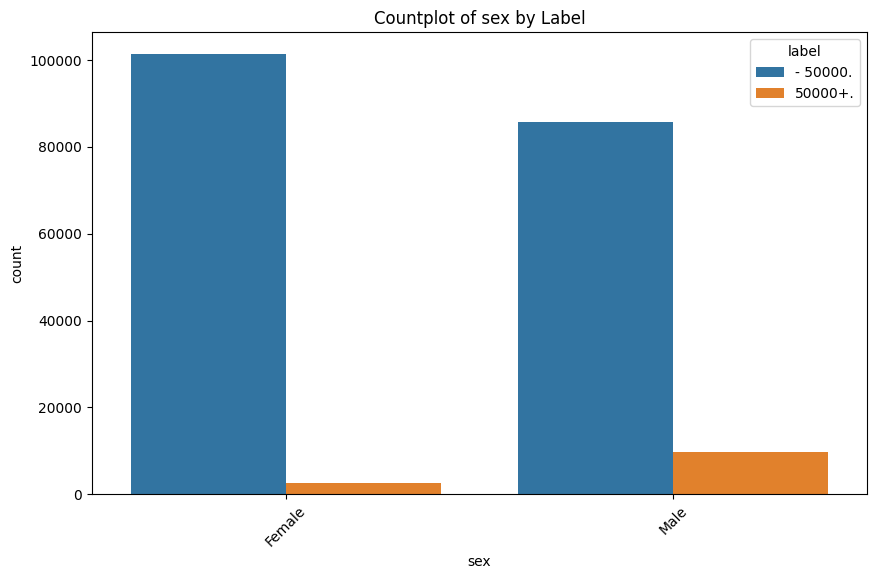

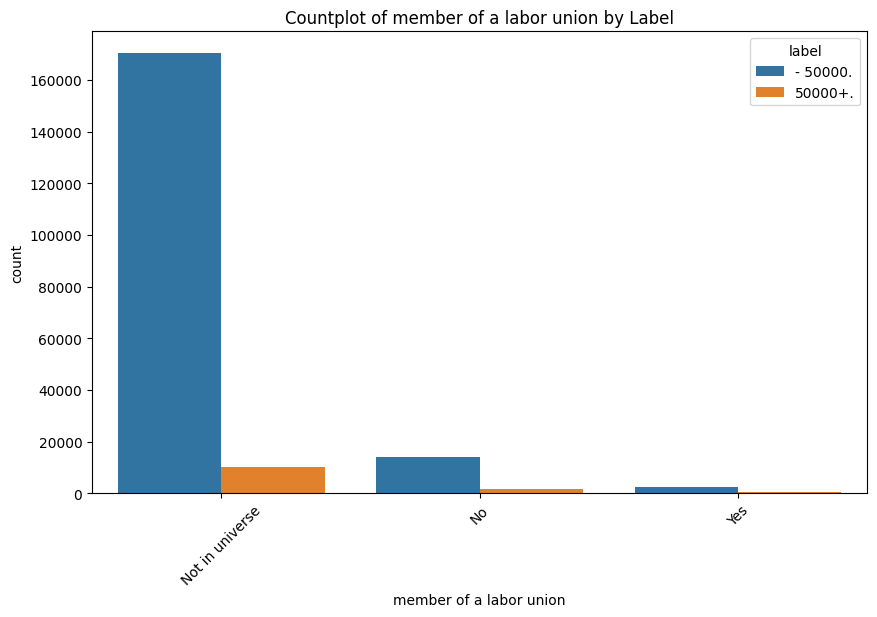

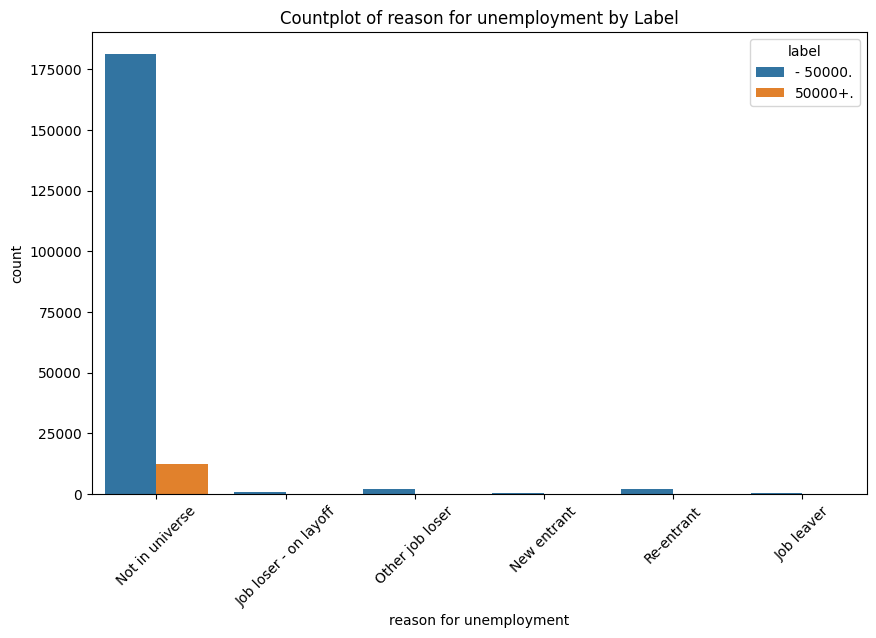

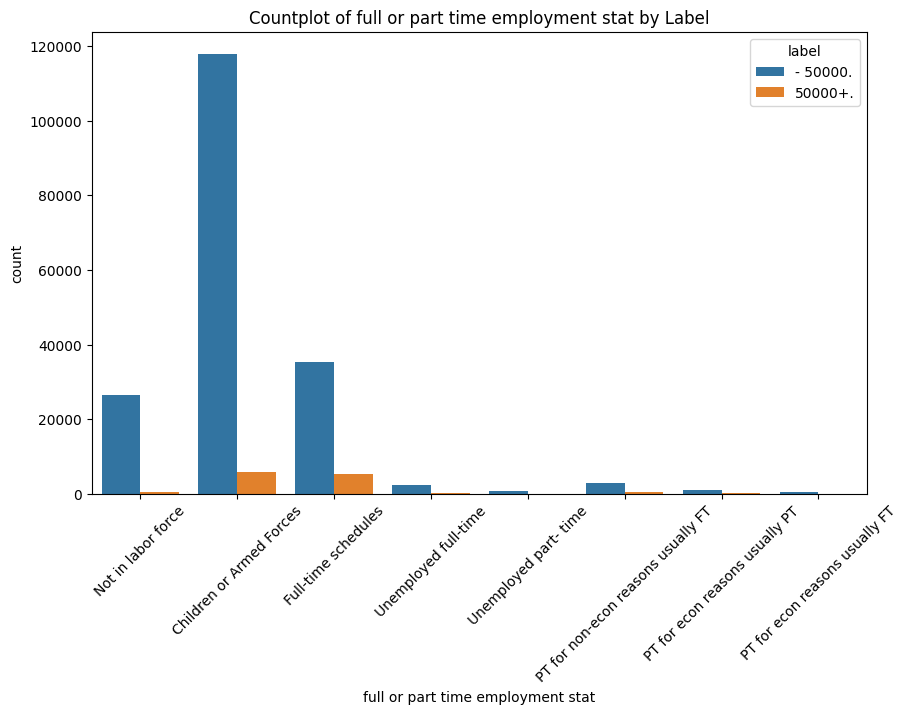

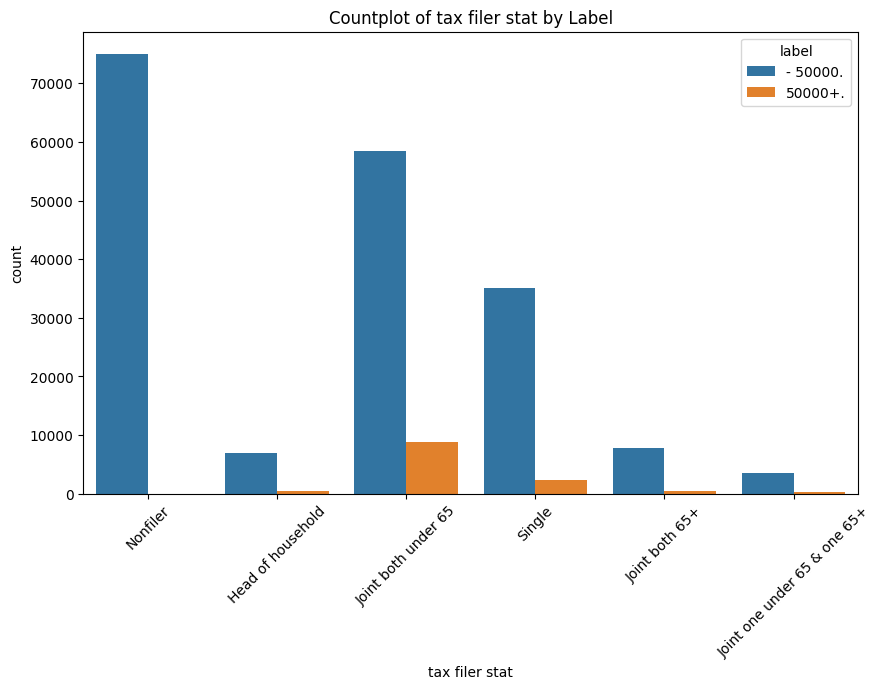

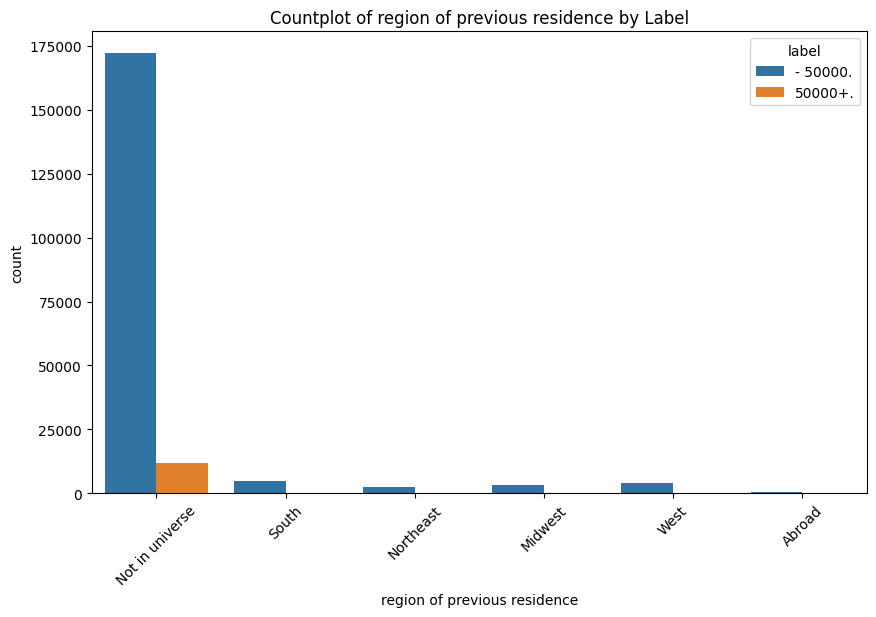

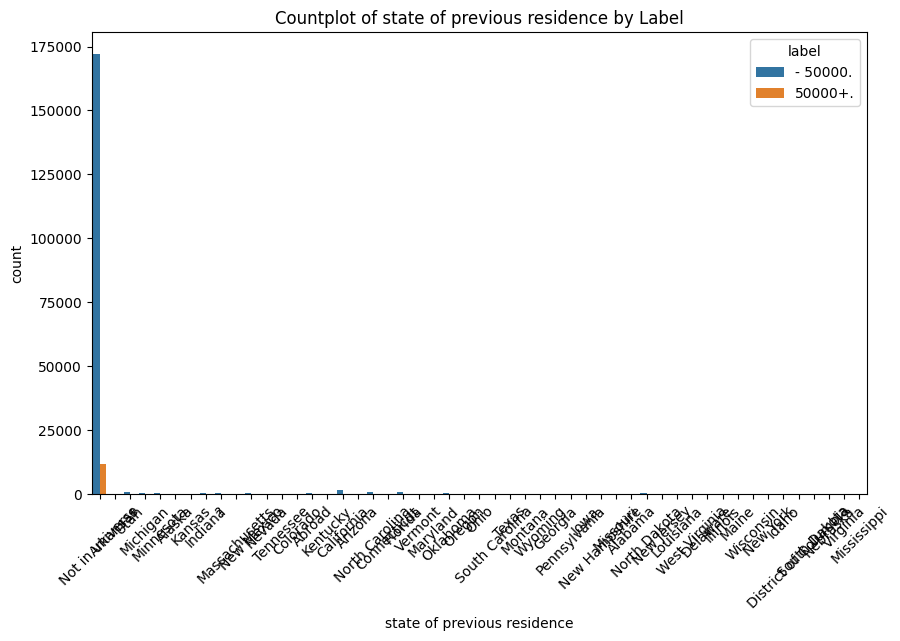

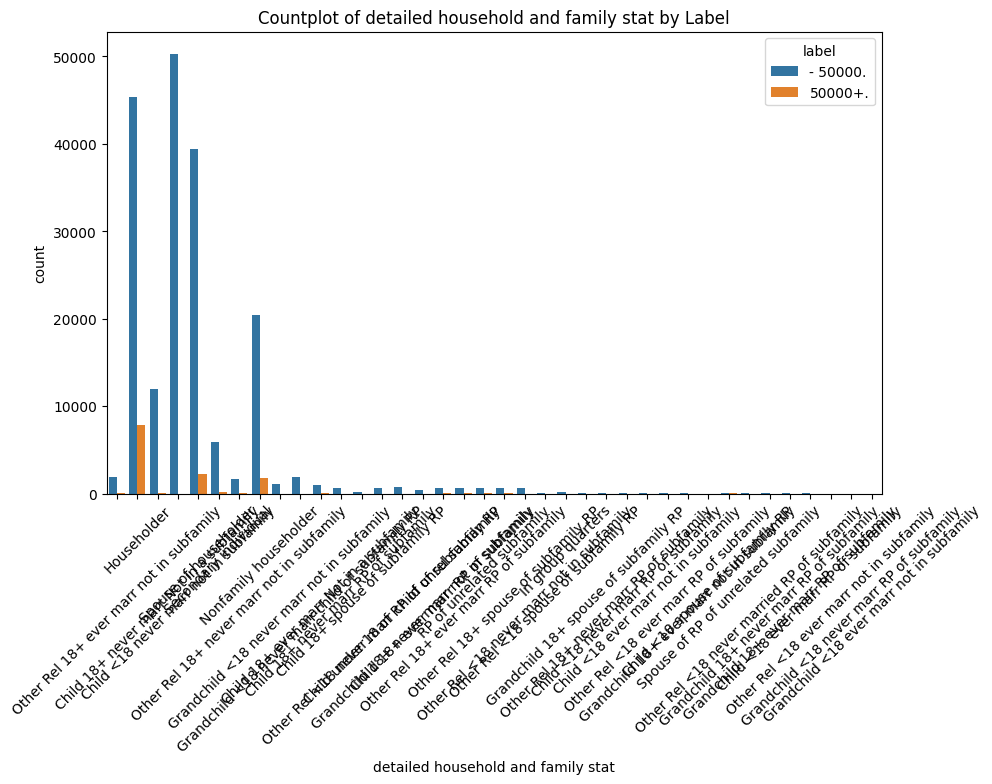

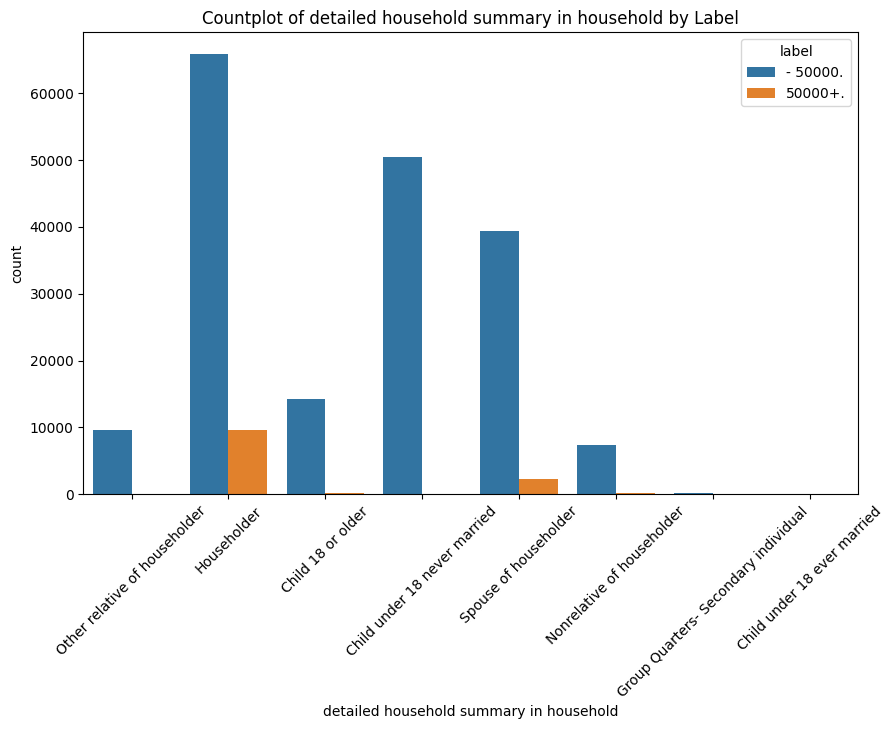

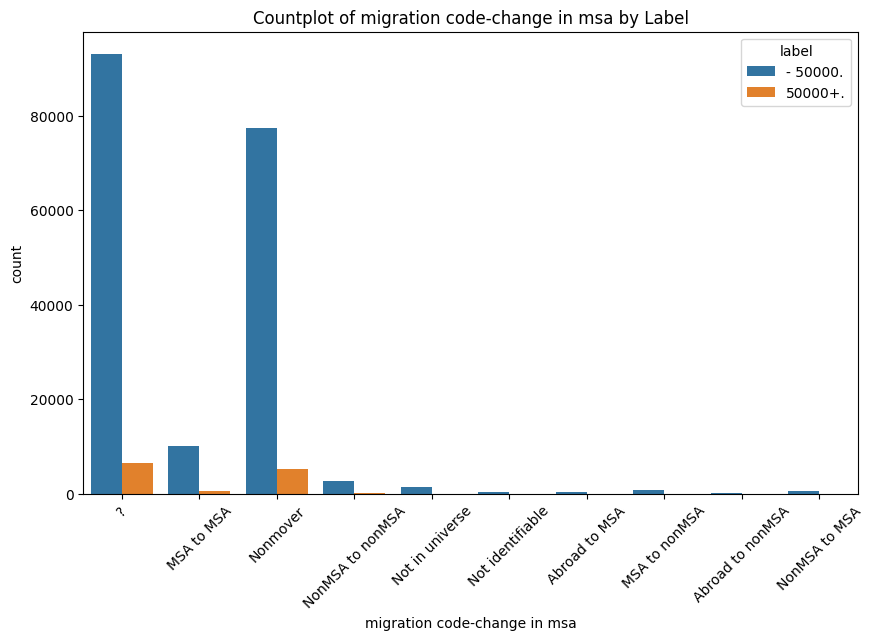

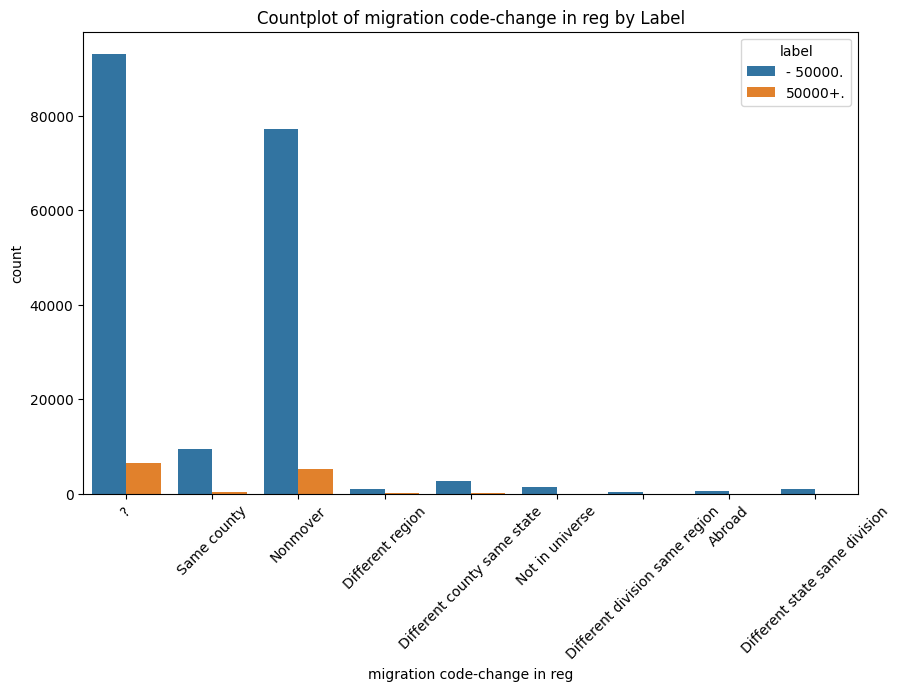

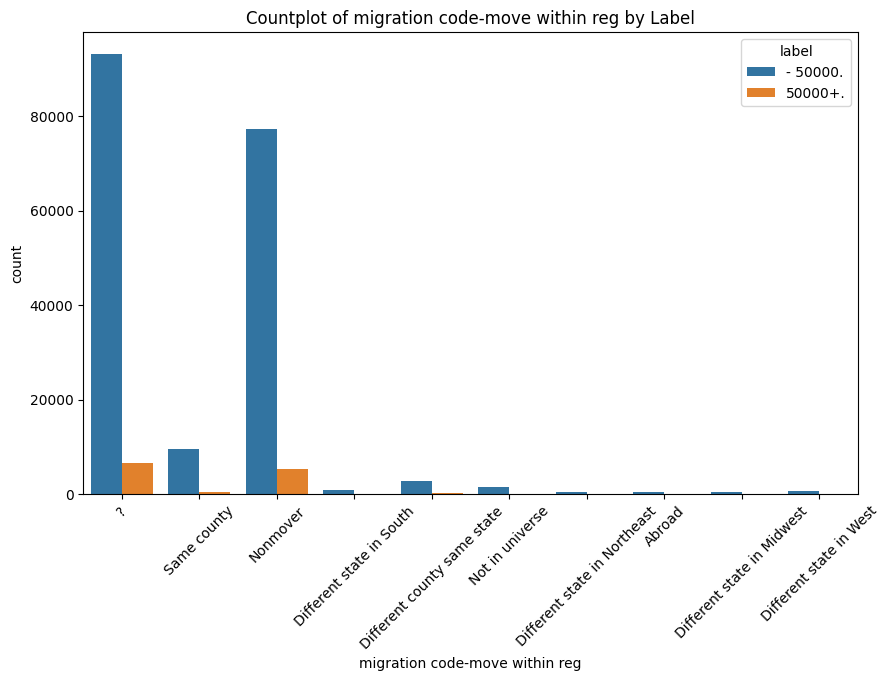

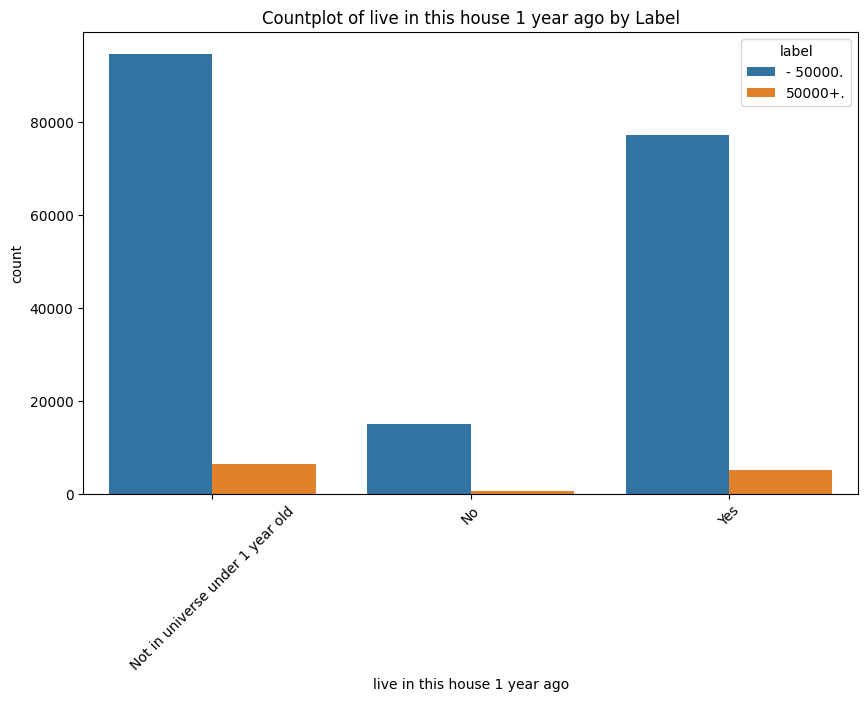

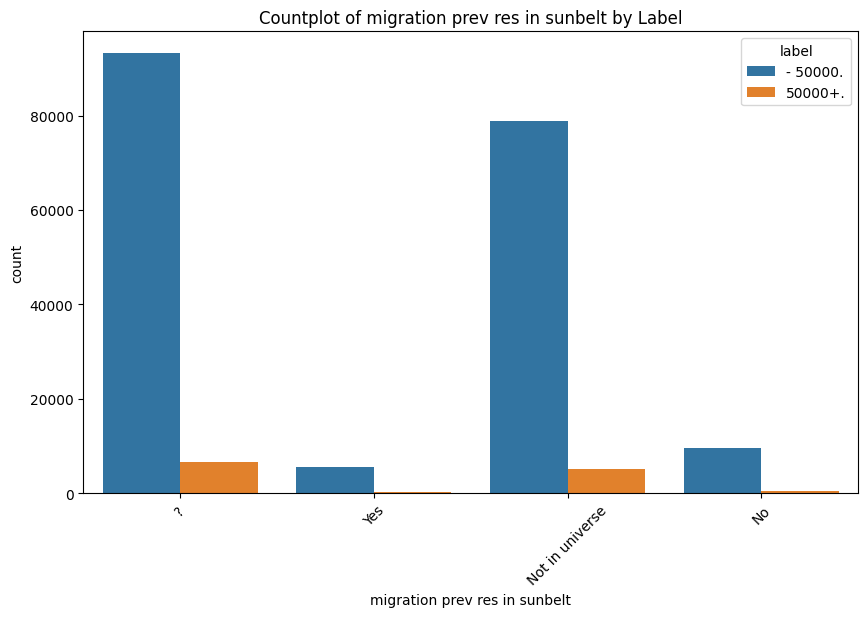

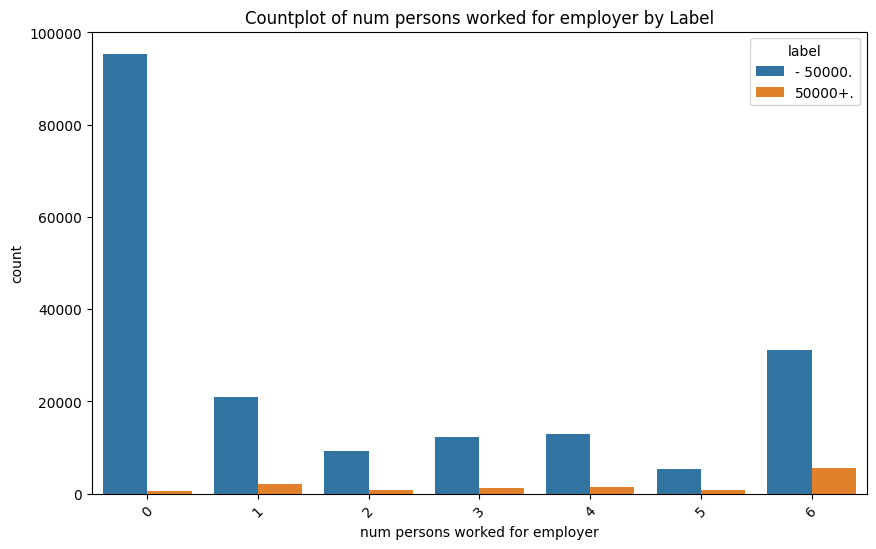

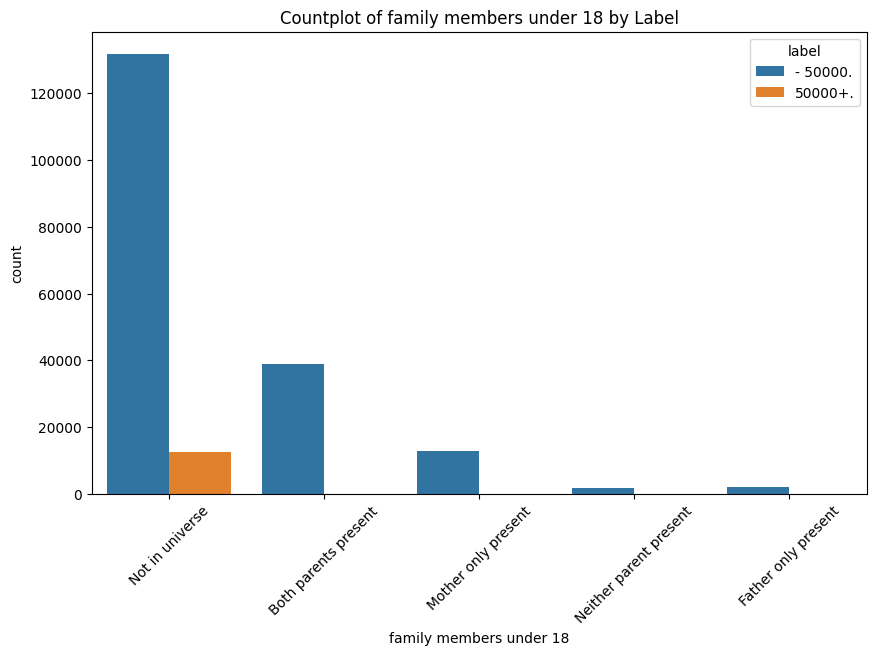

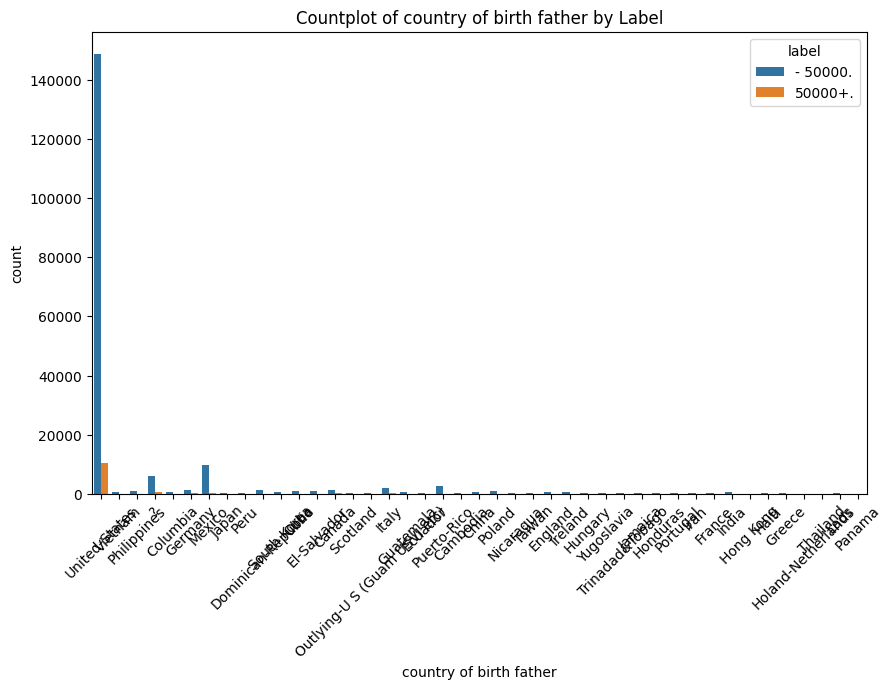

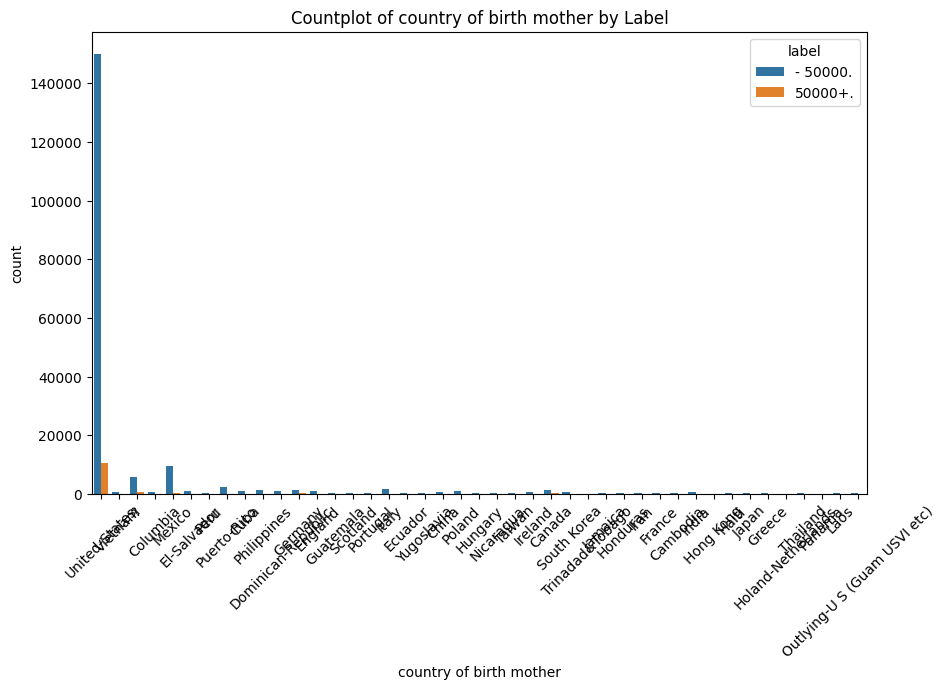

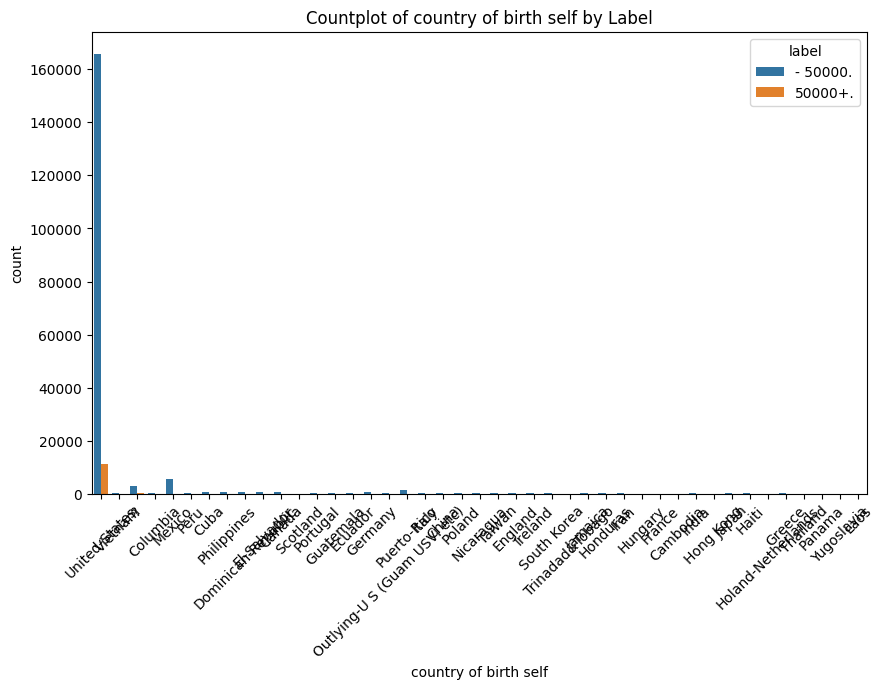

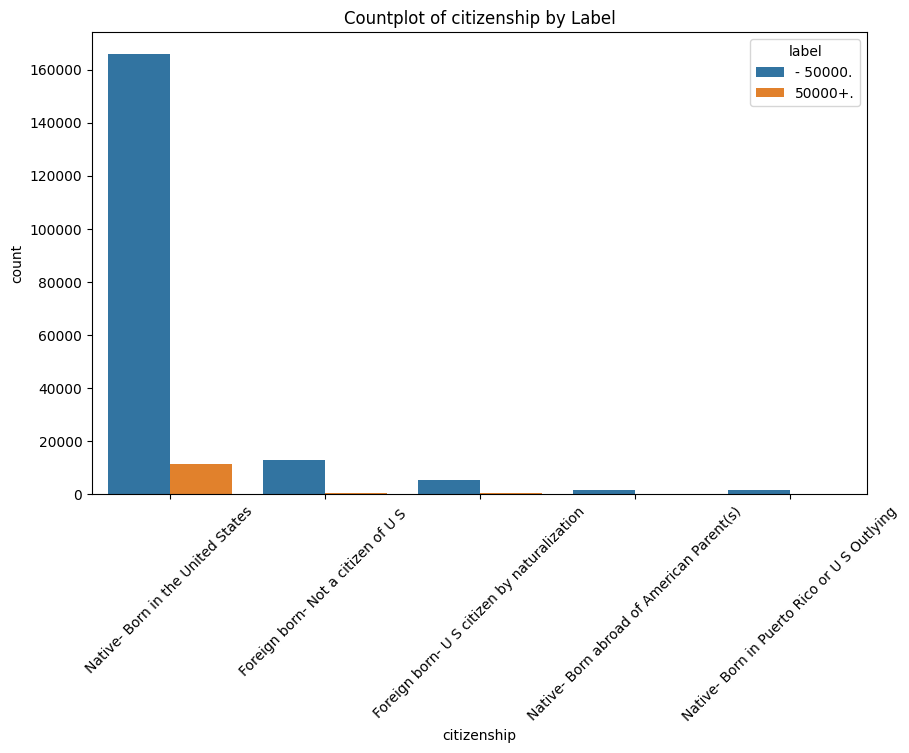

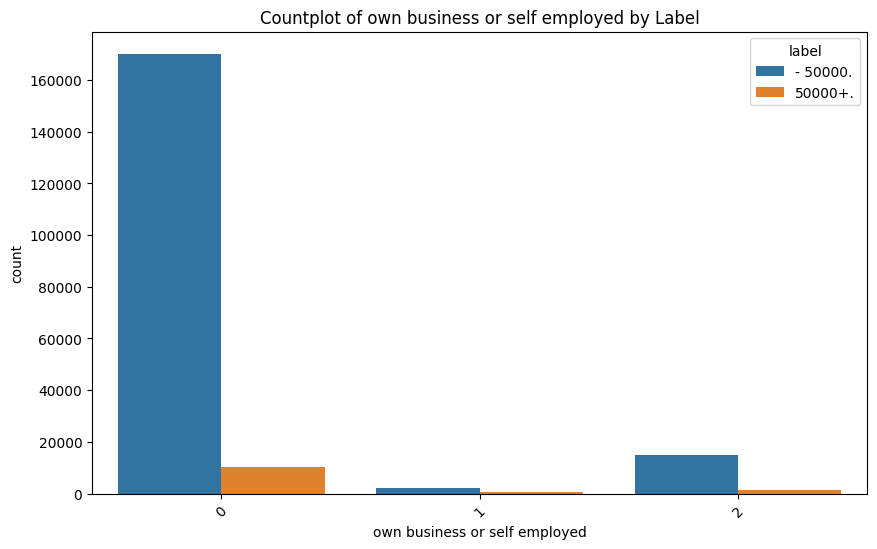

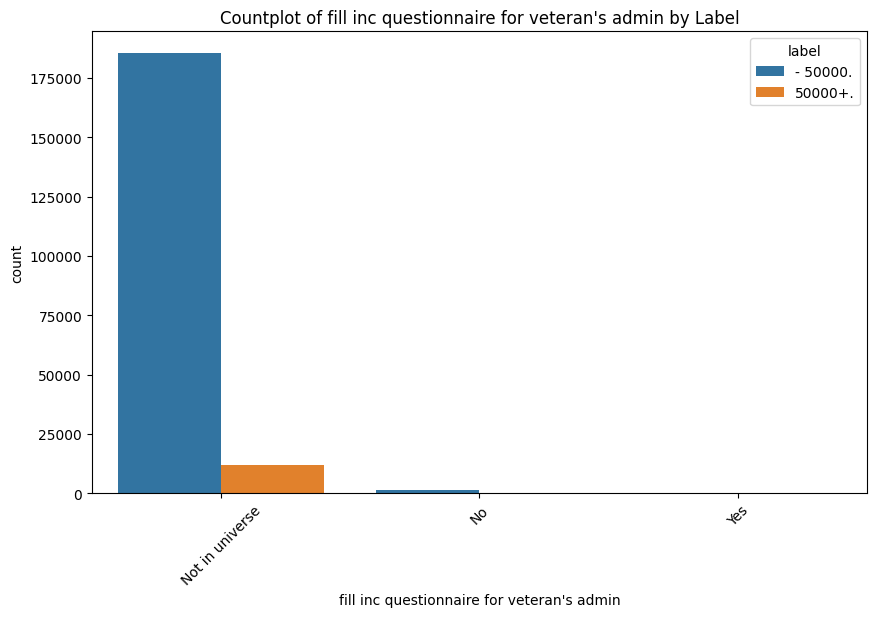

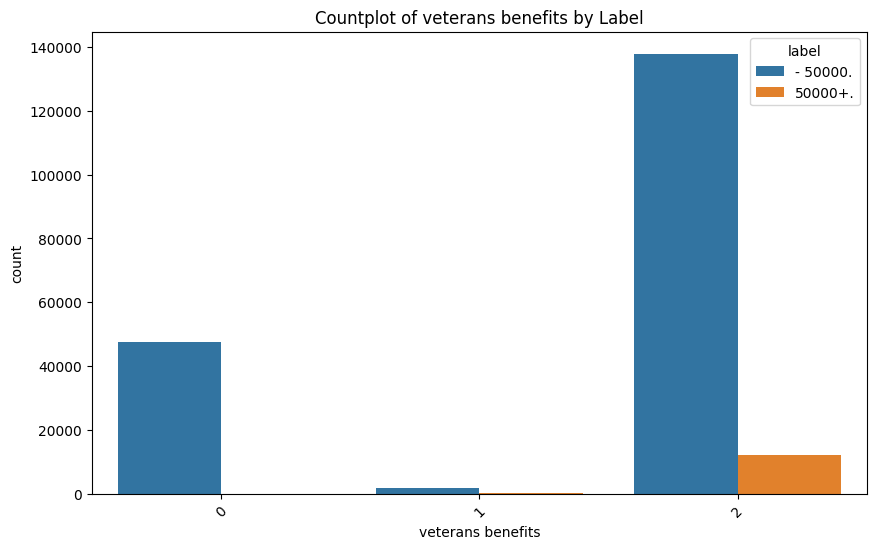

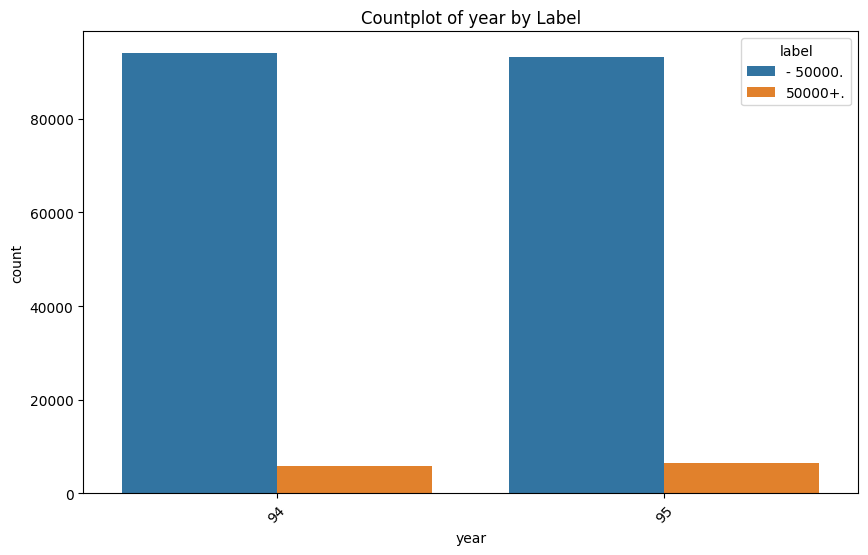

In [17]:
# Understanding the reason for "Not in universe": histogram for categorical features
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='label')
    plt.title(f'Countplot of {col} by Label')
    plt.xticks(rotation=45)
    plt.show()

In [18]:
features['citizenship'].value_counts()

citizenship
Native- Born in the United States              176992
Foreign born- Not a citizen of U S              13401
Foreign born- U S citizen by naturalization      5855
Native- Born abroad of American Parent(s)        1756
Native- Born in Puerto Rico or U S Outlying      1519
Name: count, dtype: int64

some categorical features have numerical value labels, use codebook to map them to string labels
- https://cps.ipums.org/cps/resources/codebooks/cpsmar96.pdf
- VETYN veterans_benefits: 0 1 2
    - page 128
    - 0 .Not in universe: missing data?
    - 1 .Yes
    - 2 .No 
- SEOTR own_business_or_self_employed: 0 1 2
    - page 206
    - 0 .Not in universe: missing data?
    - 1 .Yes
    - 2 .No 
- NOEMP num_persons_worked_for_employer: 0 1 2 3 4 5 6
    - page 203
    - 0 .Not in universe
    - 1 .Under 10
    - 2 .10 - 24
    - 3 .25 - 99
    - 4 .100 - 499
    - 5 .500 - 999
    - 6 .1000+ 

In [19]:
features[categorical_cols].nunique().sum()

np.int64(509)

In [20]:
# Is there any missing data in categorical features? show only those with missing values
features[categorical_cols].isnull().sum()[features[categorical_cols].isnull().sum() > 0]

hispanic origin    874
dtype: int64

In [21]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, 
                        min_frequency=500,
                        drop='first',  # drop first to avoid dummy variable trap
                        handle_unknown='ignore') # fill with nan

features_encoded = encoder.fit_transform(features[categorical_cols])
encoded_cols = encoder.get_feature_names_out(categorical_cols)
features_encoded = pd.DataFrame(features_encoded, columns=encoded_cols)
features_encoded.head()

,class of worker_Local government,class of worker_Not in universe,class of worker_Private,class of worker_Self-employed-incorporated,class of worker_Self-employed-not incorporated,class of worker_State government,class of worker_infrequent_sklearn,detailed industry recode_1,detailed industry recode_2,detailed industry recode_3,...,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,own business or self employed_1,own business or self employed_2,fill inc questionnaire for veteran's admin_Not in universe,fill inc questionnaire for veteran's admin_infrequent_sklearn,veterans benefits_1,veterans benefits_2,year_95
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Feature Engineering

1. How is this person doing financially?
    - own business or self employed  
    - num persons worked for employer   
    - tax filer stat           
    - full or part time employment stat   
    - weeks worked in year
    - capital losses
    - capital gains
    - wage per hour
    - dividends from stocks    

In [22]:
# net capital gain and loss
features['net capital gains'] = features['capital gains'] - features['capital losses']
# has dividends or not
features['has dividends'] = (features['dividends from stocks'] > 0).astype(int)
# total income
features['total income'] = features['weeks worked in year'] * features['wage per hour'] * 8 * 5 \
                            + features['net capital gains'] \
                            + features['dividends from stocks']

In [23]:
features['full or part time employment stat'].value_counts()

full or part time employment stat
Children or Armed Forces              123769
Full-time schedules                    40736
Not in labor force                     26808
PT for non-econ reasons usually FT      3322
Unemployed full-time                    2311
PT for econ reasons usually PT          1209
Unemployed part- time                    843
PT for econ reasons usually FT           525
Name: count, dtype: int64

In [24]:
# Employment Status:
def refined_employment_status(x):
    # Group 1: Currently Employed, Full-Time
    if x == 'Full-time schedules':
        return 'full-time'
    
    # Group 2: Currently Employed, Part-Time (regardless of the reason)
    elif x in ['PT for econ reasons usually FT', 
               'PT for non-econ reasons usually FT', 
               'PT for econ reasons usually PT']:
        return 'part-time'
        
    # Group 3: Currently Unemployed (actively seeking work)
    elif x in ['Unemployed full-time', 'Unemployed part- time']:
        return 'unemployed'
        
    # Group 4: Not in the labor force (not working, not seeking work)
    else: # This will catch 'Not in labor force', 'Disabled', etc.
        return 'not-in-labor-force'
    
features['refined employment status'] = features['full or part time employment stat'].apply(refined_employment_status)
features['refined employment status'].value_counts()

refined employment status
not-in-labor-force    150577
full-time              40736
part-time               5056
unemployed              3154
Name: count, dtype: int64

In [25]:
features['refined employment status from hours worked'] = features['weeks worked in year'].apply(
    lambda x: "full-time" if x > 50 else "part-time" if x > 0 else "not-in-labor-force"
)
# compare the two refined employment status
pd.crosstab(features['refined employment status'], features['refined employment status from hours worked'])

refined employment status from hours worked,full-time,not-in-labor-force,part-time
refined employment status,,,
full-time,30788,926,9022
not-in-labor-force,36222,94173,20182
part-time,3415,118,1523
unemployed,708,766,1680


To create a robust feature for employment, we explored two definitions: one based on the respondent's self-identified employment status and another based on the literal number of weeks worked. 

A crosstabulation (see table above) revealed significant discrepancies between the two approaches. 
The self-identified status proved to be a more nuanced and powerful feature. For example, it successfully isolated a distinct 'unemployed' population that the hours-worked metric could not. It also highlighted a large cohort of individuals (~36,000) who worked a full year but do not identify as being in the formal labor force, suggesting a more complex employment situation.
Given its ability to capture these critical subtleties that are highly relevant for assessing financial stability, we have proceeded with the refined employment status feature for our final model.

2. Life Stages
     - Age
     - education         
     - enroll in edu inst last wk   
     - marital stat 
     - detailed household summary in household 
     - family members under 18   

In [26]:
# Age squared
features['age_squared'] = features['age'] ** 2
# Age grouping
def age_grouping(age):
    if age < 18:
        return 'under_18'
    elif 18 <= age < 30:
        return '18-29'
    elif 30 <= age < 45:
        return '30-44'
    elif 45 <= age < 60:
        return '45-59'
    elif 60 <= age < 75:
        return '60-74'
    else:
        return '75_and_above'
features['age_group'] = features['age'].apply(age_grouping)
features['age_group'].value_counts()

age_group
under_18        55992
30-44           47991
18-29           32142
45-59           31441
60-74           21729
75_and_above    10228
Name: count, dtype: int64

In [27]:
features['marital stat'].value_counts()

marital stat
Never married                      86485
Married-civilian spouse present    84222
Divorced                           12710
Widowed                            10463
Separated                           3460
Married-spouse absent               1518
Married-A F spouse present           665
Name: count, dtype: int64

In [28]:
# marital status and age interaction
def marital_age_interaction(row):
    if row['marital stat'] in ['Married-civilian spouse present', 'Married-A F spouse present']:
        if row['age'] < 30:
            return 'young_married'
        elif 30 <= row['age'] < 60:
            return 'midage_married'
        else:
            return 'senior_married'
    else:
        if row['age'] < 30:
            return 'young_not_married'
        elif 30 <= row['age'] < 60:
            return 'midage_not_married'
        else:
            return 'senior_not_married'
features['marital_age_group'] = features.apply(marital_age_interaction, axis=1)
features['marital_age_group'].value_counts()

marital_age_group
young_not_married     77696
midage_married        55732
midage_not_married    23700
senior_married        18717
senior_not_married    13240
young_married         10438
Name: count, dtype: int64

In [29]:
features['education'].value_counts()

education
High school graduate                      48407
Children                                  47422
Some college but no degree                27820
Bachelors degree(BA AB BS)                19865
7th and 8th grade                          8007
10th grade                                 7557
11th grade                                 6876
Masters degree(MA MS MEng MEd MSW MBA)     6541
9th grade                                  6230
Associates degree-occup /vocational        5358
Associates degree-academic program         4363
5th or 6th grade                           3277
12th grade no diploma                      2126
1st 2nd 3rd or 4th grade                   1799
Prof school degree (MD DDS DVM LLB JD)     1793
Doctorate degree(PhD EdD)                  1263
Less than 1st grade                         819
Name: count, dtype: int64

In [30]:
# education level grouping
def group_education(education_level):
    # Group 1: Children
    if education_level == 'Children':
        return 'Children'

    # Group 2: No High School Diploma
    elif education_level in ['Less than 1st grade', '1st 2nd 3rd or 4th grade', 
                             '5th or 6th grade', '7th and 8th grade', 
                             '9th grade', '10th grade', '11th grade', 
                             '12th grade no diploma']:
        return 'No-High-School'

    # Group 3: High School Graduate
    elif education_level == 'High school graduate':
        return 'High-School-Graduate'

    # Group 4: Some College (including Associates)
    elif education_level in ['Some college but no degree', 
                             'Associates degree-occup /vocational', 
                             'Associates degree-academic program']:
        return 'Some-College'

    # Group 5: Bachelors Degree
    elif education_level == 'Bachelors degree(BA AB BS)':
        return 'Bachelors-Degree'

    # Group 6: Advanced Degree
    elif education_level in ['Masters degree(MA MS MEng MEd MSW MBA)', 
                             'Prof school degree (MD DDS DVM LLB JD)',
                             'Doctorate degree(PhD EdD)']:
        return 'Advanced-Degree'
    
    # Fallback for any unexpected values
    else:
        return 'Other'

features['education_group'] = features['education'].apply(group_education)
print(features['education_group'].value_counts())

education_group
High-School-Graduate    48407
Children                47422
Some-College            37541
No-High-School          36691
Bachelors-Degree        19865
Advanced-Degree          9597
Name: count, dtype: int64


In [31]:
# education and age interaction
def education_age_interaction(row):
    if row['education'] in ['Bachelors', 'Masters', 'Doctorate', 'Prof-school']:
        if row['age'] < 30:
            return 'young_high_edu'
        elif 30 <= row['age'] < 60:
            return 'midage_high_edu'
        else:
            return 'senior_high_edu'
    else:
        if row['age'] < 30:
            return 'young_low_edu'
        elif 30 <= row['age'] < 60:
            return 'midage_low_edu'
        else:
            return 'senior_low_edu'

3. Immigration Status
    - migration prev res in sunbelt    
    - state of previous residence   
    - citizenship      
    - race
    - hispanic origin 
    - region of previous residence       
    - country of birth father
    - country of birth mother
    - country of birth self
    - migration code-change in reg
    - migration code-move within reg
    - migration code-change in msa          

In [32]:
# first generation immigrant & second generation
    # - country of birth father
    # - country of birth mother
    # - country of birth self
features['immigrant_status'] = features.apply(lambda row: 
    'first_gen' 
        if row['country of birth self'] != 'United-States' 
            and row['country of birth father'] != 'United-States' 
            and row['country of birth mother'] != 'United-States'
        else ('second_gen' 
            if row['country of birth father'] != 'United-States' 
                or row['country of birth mother'] != 'United-States' 
            else 'native'), axis=1)
features['immigrant_status'].value_counts()

immigrant_status
native        154206
second_gen     24410
first_gen      20907
Name: count, dtype: int64

In [33]:
# write this feature engineering pipeline into a function for later use
def feature_engineering(features):
    # net capital gain and loss
    features['net capital gains'] = features['capital gains'] - features['capital losses']
    # has dividends or not
    features['has dividends'] = (features['dividends from stocks'] > 0).astype(int)
    # total income
    features['total income'] = features['weeks worked in year'] * features['wage per hour'] * 8 * 5 \
                                + features['net capital gains'] \
                                + features['dividends from stocks']

    # refined employment status
    def refined_employment_status(x):
        if x == 'Full-time schedules':
            return 'full-time'
        elif x in ['PT for econ reasons usually FT', 
                   'PT for non-econ reasons usually FT', 
                   'PT for econ reasons usually PT']:
            return 'part-time'
        elif x in ['Unemployed full-time', 'Unemployed part- time']:
            return 'unemployed'
        else:
            return 'not-in-labor-force'
        
    features['refined employment status'] = features['full or part time employment stat'].apply(refined_employment_status)

    # Age squared
    features['age_squared'] = features['age'] ** 2
    # Age grouping
    def age_grouping(age):
        if age < 18:
            return 'under_18'
        elif 18 <= age < 30:
            return '18-29'
        elif 30 <= age < 45:
            return '30-44'
        elif 45 <= age < 60:
            return '45-59'
        elif 60 <= age < 75:
            return '60-74'
        else:
            return '75_and_above'
    features['age_group'] = features['age'].apply(age_grouping)

    # marital status and age interaction
    def marital_age_interaction(row):
        if row['marital stat'] in ['Married-civilian spouse present', 'Married-A F spouse present']:
            if row['age'] < 30:
                return 'young_married'
            elif 30 <= row['age'] < 60:
                return 'midage_married'
            else:
                return 'senior_married'
        else:
            if row['age'] < 30:
                return 'young_not_married'
            elif 30 <= row['age'] < 60:
                return 'midage_not_married'
            else:
                return 'senior_not_married'
    features['marital_age_interaction'] = features.apply(marital_age_interaction, axis=1)
    
    # education level grouping
    def group_education(education_level):
        # Group 1: Children
        if education_level == 'Children':
            return 'Children'

        # Group 2: No High School Diploma
        elif education_level in ['Less than 1st grade', '1st 2nd 3rd or 4th grade', 
                                '5th or 6th grade', '7th and 8th grade', 
                                '9th grade', '10th grade', '11th grade', 
                                '12th grade no diploma']:
            return 'No-High-School'

        # Group 3: High School Graduate
        elif education_level == 'High school graduate':
            return 'High-School-Graduate'

        # Group 4: Some College (including Associates)
        elif education_level in ['Some college but no degree', 
                                'Associates degree-occup /vocational', 
                                'Associates degree-academic program']:
            return 'Some-College'

        # Group 5: Bachelors Degree
        elif education_level == 'Bachelors degree(BA AB BS)':
            return 'Bachelors-Degree'

        # Group 6: Advanced Degree
        elif education_level in ['Masters degree(MA MS MEng MEd MSW MBA)', 
                                'Prof school degree (MD DDS DVM LLB JD)',
                                'Doctorate degree(PhD EdD)']:
            return 'Advanced-Degree'
        
        # Fallback for any unexpected values
        else:
            return 'Other'

    features['education_group'] = features['education'].apply(group_education)
    print(features['education_group'].value_counts())
    
    # education and age interaction
    def education_age_interaction(row):
        if row['education'] in ['Bachelors', 'Masters', 'Doctorate', 'Prof-school']:
            if row['age'] < 30:
                return 'young_high_edu'
            elif 30 <= row['age'] < 60:
                return 'midage_high_edu'
            else:
                return 'senior_high_edu'
        else:
            if row['age'] < 30:
                return 'young_low_edu'
            elif 30 <= row['age'] < 60:
                return 'midage_low_edu'
            else:
                return 'senior_low_edu'

    return features

### 3. Create Training and Test Data Sets

In [34]:
X = features_encoded
y = labels

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_featured, 
    y, 
    test_size=config.TEST_SIZE, 
    random_state=config.RANDOM_STATE,
    stratify=y # To maintain class distribution in splits
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nTest set target distribution:\n{y_test.value_counts(normalize=True)}")

NameError: name 'X_featured' is not defined

### 4. Model Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import config
from sklearn.preprocessing import preprocessor


# The full pipeline by combining our preprocessor with the classifier
lr_pipeline_standard = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=config.RANDOM_STATE, max_iter=1000))
])

# Perform 5-fold cross-validation
cv_auc_standard = cross_val_score(
    lr_pipeline_standard, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1
)

cv_f1_standard = cross_val_score(
    lr_pipeline_standard, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1
)

# To see how the model performs for underrepresented classes
cv_f1_macro = cross_val_score(
    lr_pipeline_standard, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1
)

print("\nResults for Standard Logistic Regression (5-fold CV):")
print(f"  Mean ROC AUC: {np.mean(cv_auc_standard):.4f} (Std: {np.std(cv_auc_standard):.4f})")
print(f"  Mean F1-Score (Weighted): {np.mean(cv_f1_standard):.4f} (Std: {np.std(cv_f1_standard):.4f})")
print(f"  Mean F1-Score (Macro): {np.mean(cv_f1_macro):.4f} (Std: {np.std(cv_f1_macro):.4f})")